<a href="https://colab.research.google.com/github/DLShrankhala/DevelopingVariousLSTMModelForTimeSeriesForecasting-ai-25/blob/main/Nishith_AQI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [96]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import math

# Load the dataset
file_path = 'station.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
data.head()

# Preprocess the data
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date')
data = data[['Date', 'AQI']]

# Handle missing values
data = data.dropna()

# Normalize the AQI values
scaler = MinMaxScaler(feature_range=(0, 1))
data['AQI'] = scaler.fit_transform(data['AQI'].values.reshape(-1,1))

# Create a new DataFrame with normalized data
data.set_index('Date', inplace=True)
data.head()


,AQI
Date,
2015-01-01,0.174424
2015-01-01,0.279765
2015-01-02,0.196962
2015-01-02,0.239588
2015-01-03,0.065164


In [97]:
# Create sequences for LSTM
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data.iloc[i:(i + seq_length)].values
        y = data.iloc[i + seq_length].values
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 30
X, y = create_sequences(data, SEQ_LENGTH)

# Split the data into training and testing sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [103]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(SEQ_LENGTH, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/50
1740/1740 [==============================] - 54s 29ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 2/50
1740/1740 [==============================] - 51s 29ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 3/50
1740/1740 [==============================] - 49s 28ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 4/50
1692/1740 [============================>.] - ETA: 1s - loss: 0.0034

KeyboardInterrupt: 

In [104]:
# Make predictions
y_pred = model.predict(X_test)

# Inverse transform the predictions and true values
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

# Calculate RMSE
rmse = math.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print(f'RMSE: {rmse}')




544/544 [==============================] - 6s 9ms/step
RMSE: 72.78523917728882


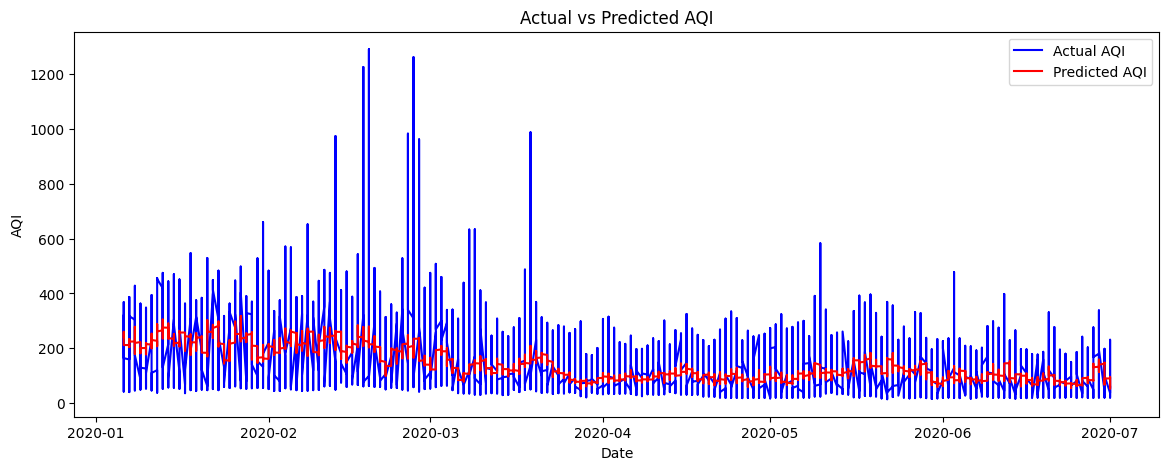

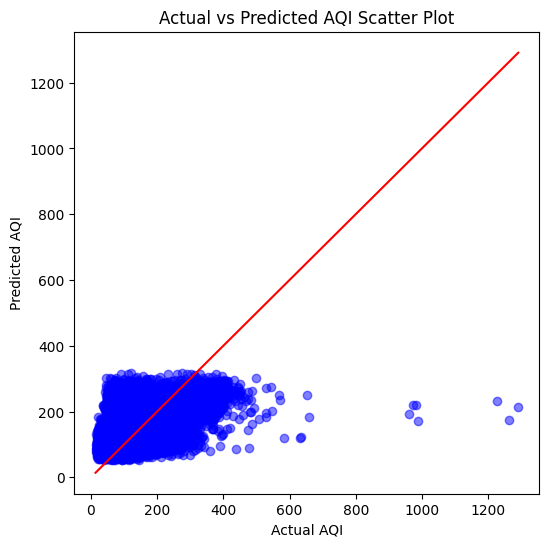

In [102]:
# Visualize the actual and predicted AQI values
plt.figure(figsize=(14, 5))
plt.plot(data.index[-len(y_test_inv):], y_test_inv, color='blue', label='Actual AQI')
plt.plot(data.index[-len(y_pred_inv):], y_pred_inv, color='red', label='Predicted AQI')
plt.title('Actual vs Predicted AQI')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.legend()
plt.show()

# Scatter plot of actual vs predicted AQI values
plt.figure(figsize=(6, 6))
plt.scatter(y_test_inv, y_pred_inv, color='blue', alpha=0.5)
plt.plot([min(y_test_inv), max(y_test_inv)], [min(y_test_inv), max(y_test_inv)], color='red')
plt.title('Actual vs Predicted AQI Scatter Plot')
plt.xlabel('Actual AQI')
plt.ylabel('Predicted AQI')
plt.show()
